In [1]:
%load_ext autoreload
%autoreload 3 --print

In [50]:
from argparse import Namespace
import joblib as jl

from kpsn_test.routines.util import load_cfg, save_results, update, find_file

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

from kpsn.util import keypt_io
from kpsn_test import visualize as viz
from kpsn.models.pose import gmm


import numpy as np
from kpsn.models.morph import affine_mode as afm
from kpsn.models.morph import linear_skeletal as ls
from kpsn.util import skeleton, alignment, logging, keypt_io
from kpsn_test import visualize as viz
import numpy as np
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt
import seaborn as sns
import jax.tree_util as pt
import os

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plot_dir = '../../plots/notebook/blscale_err_incr'

plt.style.use("vscode_dark")
sns.set_context('paper')

age_pal_type = viz.defaults.autumn_pal
clr = Namespace(bg_dot = '.4')

### Setup

In [74]:
model_name = 'blscale_gmm-l5lock_morph-l0_nmp'
# model_name = 'blscale_gmm-l2lock_morph-l0_nmp'
# model_name = 'blscale_gmm-l1lock_morph-l0-np'
if not os.path.exists(f'{plot_dir}/{model_name}'):
    os.mkdir(f'{plot_dir}/{model_name}')
args = Namespace(
    results_fmt = f'../../results/lra/{model_name}/' + '{}.jl',
    output_fmt = '/tmp/{}.png',
    savefig_cfg = None,
    path = (),
)

In [75]:
if len(args.path) == 1:
    override_paths = None
    fallback_fmt = args.path[0]
else:
    override_paths = {
        args.path[2*i]: args.path[2*i + 1]
        for i in range(len(args.path) // 2)}
    fallback_fmt = None

load = lambda key: jl.load(find_file(
    key, args.results_fmt, override_paths, fallback_fmt))


dataset = load('dataset')
init = load('init')
fit = load('fit')
print("Loaded data.")

results = dict(
    dataset = dataset,
    init = init,
    fit = fit)

savefig_cfg = update(dict(
    dpi = 300
    ), load_cfg(args.savefig_cfg))
savefig = lambda fmt, fig: save_results(
    args.output_fmt, fmt,
    lambda path: fig.savefig(path, **savefig_cfg))

Loaded data.


In [76]:
ref_sess = '3wk_m0'
meta = dataset['metadata']
slices = meta['session_slice']
feats = {s: dataset['keypts'][slc] for s, slc in meta['session_slice'].items()}

to_kpt, _ = alignment.gen_kpt_func(dataset['keypts'], origin_keypt = 'hips')
all_kpts = to_kpt(dataset['keypts']).reshape([-1, 14, 3])

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = age_pal_type)

In [77]:
def reconst_feat_with_params(params):
    pose = afm.inverse_transform(
        params, feats[ref_sess], meta['session_ix'][ref_sess])
    copied_poses = jnp.concatenate([pose for _ in range(params.N)])
    return afm.transform(
        params, copied_poses, dataset['subject_ids'])

ini_reconst = reconst_feat_with_params(init.morph)
fit_reconst = reconst_feat_with_params(fit['fit_params'].morph)

In [78]:
from sklearn.decomposition import PCA
pca = PCA()
all_pcs = pca.fit_transform(dataset['keypts'])
pcs = {s: all_pcs[slc] for s, slc in meta['session_slice'].items()}

ini_all_pcs = pca.transform(ini_reconst)
fit_all_pcs = pca.transform(fit_reconst)

### Reconstructed population comparisons

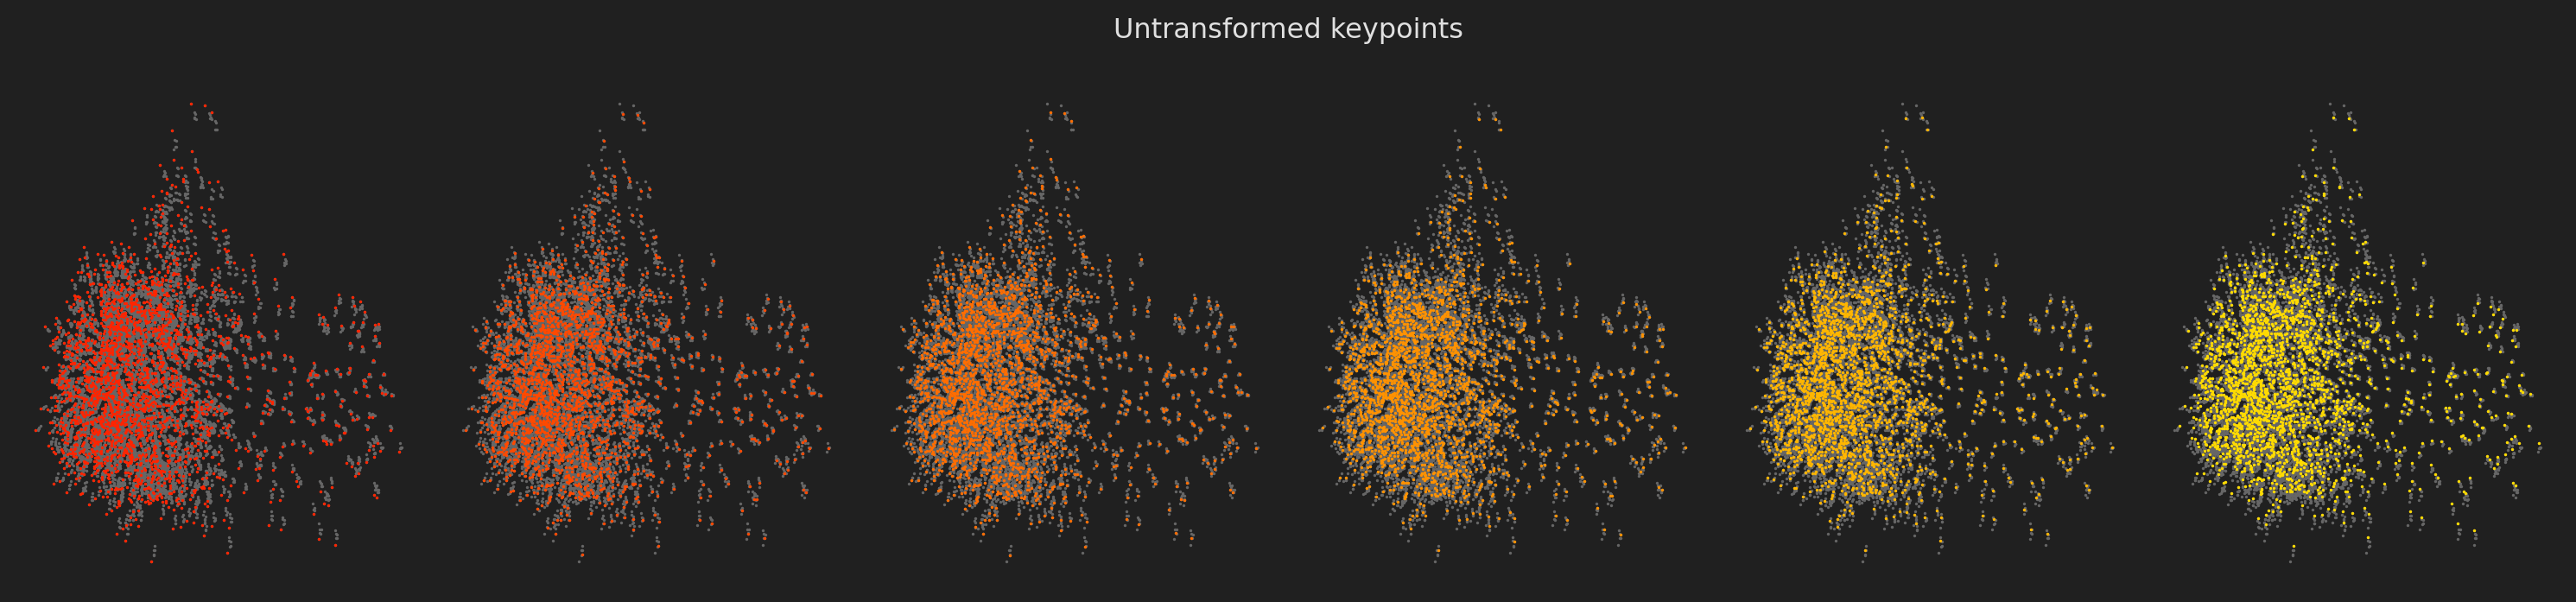

In [20]:
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True)


    
for ax, sess in zip(axes, pcs):
    ax.scatter(
        all_pcs[:, xaxis], all_pcs[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True)
    
    ax.scatter(
        pcs[sess][:, xaxis], pcs[sess][:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = age_pal[meta['tgt_age'][sess]], rasterized = True)
    
    ax.set_axis_off()

fig.suptitle("Untransformed keypoints")
fig.tight_layout()

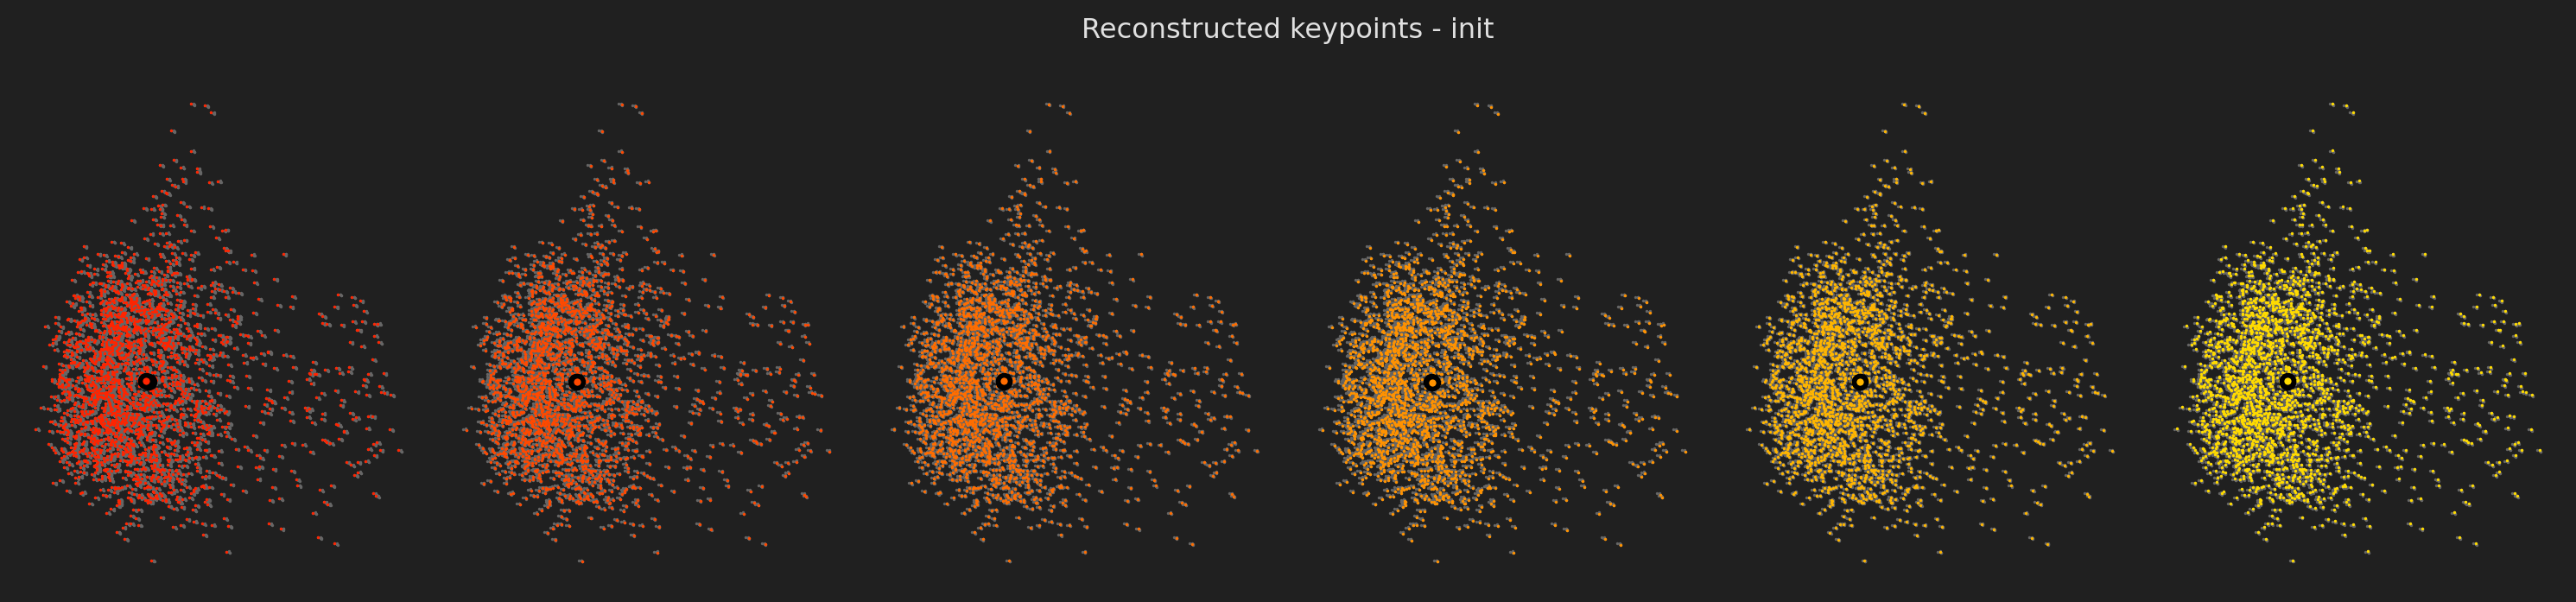

In [170]:
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True)


    
for ax, sess in zip(axes, pcs):
    ax.scatter(
        ini_all_pcs[:, xaxis], ini_all_pcs[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True, zorder = 1)
    
    sess_data = ini_all_pcs[slices[sess]]
    tgt_clr = age_pal[meta['tgt_age'][sess]]
    ax.scatter(
        sess_data[:, xaxis], sess_data[:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = tgt_clr, rasterized = True, zorder = 1)
    
    ax.plot(ini_all_pcs.mean(axis = 0)[[xaxis]], ini_all_pcs.mean(axis = 0)[[yaxis]],
        'o', color = 'w', mec = 'k', mew = 2, ms = 5, zorder = 4)
    
    ax.plot(sess_data.mean(axis = 0)[[xaxis]], sess_data.mean(axis = 0)[[yaxis]],
        'o', color = tgt_clr, mec = 'k', mew = 2, ms = 5, zorder = 4)
    
    
    
    ax.set_axis_off()

fig.suptitle("Reconstructed keypoints - init")
fig.tight_layout()

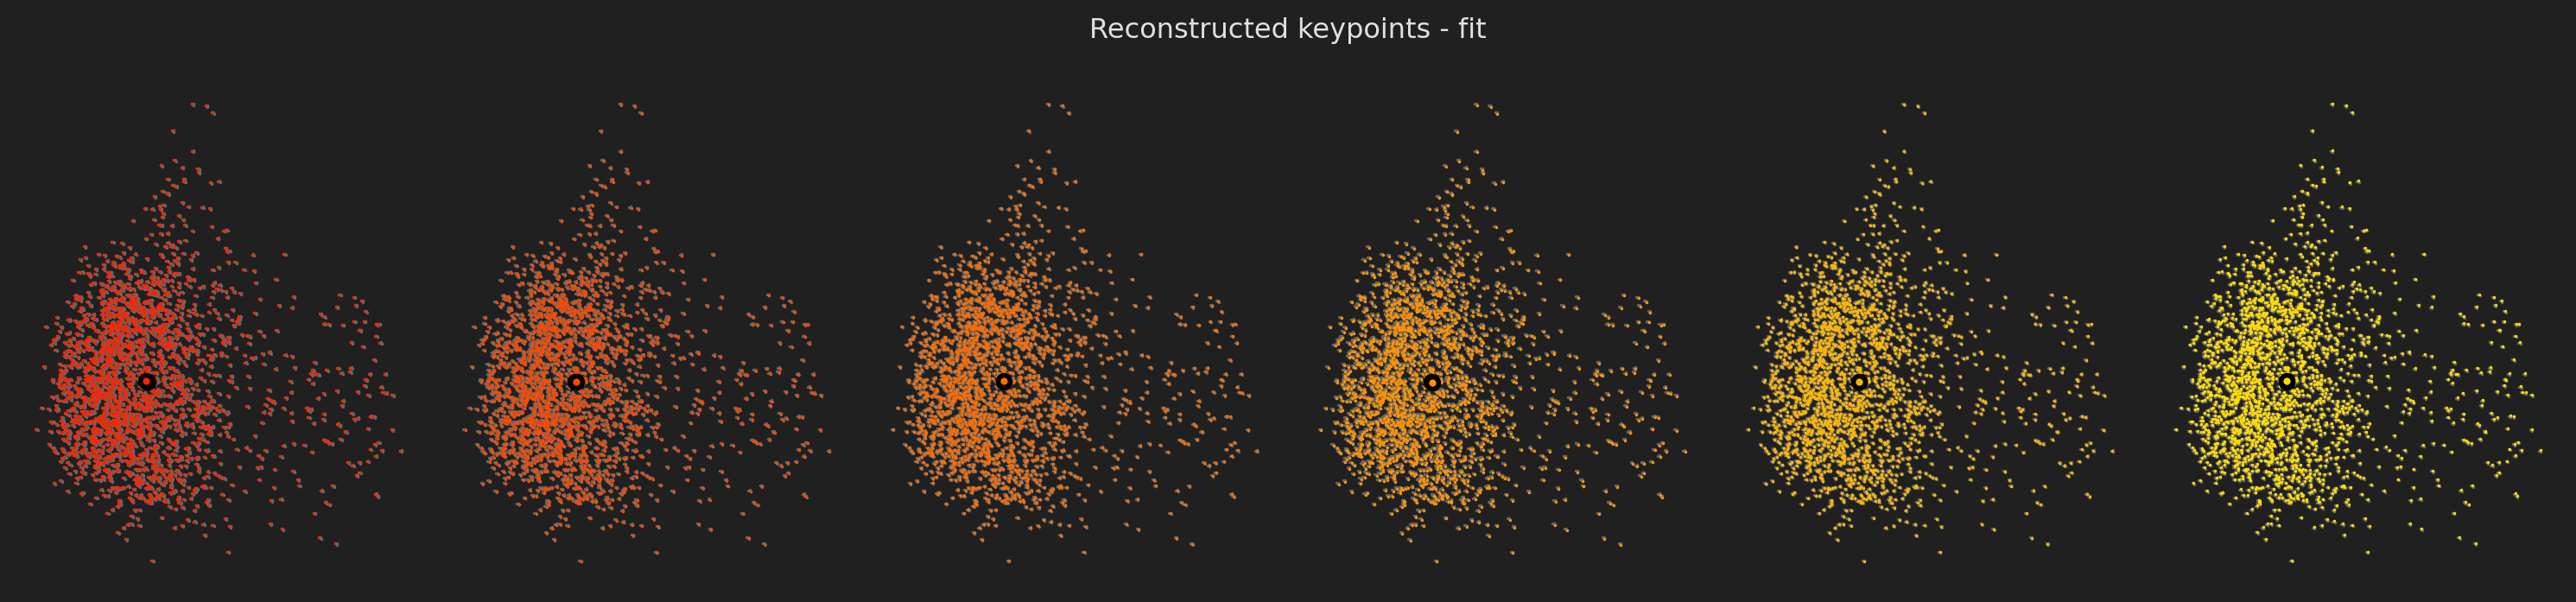

In [171]:
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True)


    
for ax, sess in zip(axes, pcs):
    ax.scatter(
        fit_all_pcs[:, xaxis], fit_all_pcs[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True, zorder = 1)
    
    sess_data = fit_all_pcs[slices[sess]]
    tgt_clr = age_pal[meta['tgt_age'][sess]]
    ax.scatter(
        sess_data[:, xaxis], sess_data[:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = tgt_clr, rasterized = True, zorder = 1)
    
    ax.plot(fit_all_pcs.mean(axis = 0)[[xaxis]], fit_all_pcs.mean(axis = 0)[[yaxis]],
        'o', color = 'w', mec = 'k', mew = 2, ms = 5, zorder = 4)
    
    ax.plot(sess_data.mean(axis = 0)[[xaxis]], sess_data.mean(axis = 0)[[yaxis]],
        'o', color = tgt_clr, mec = 'k', mew = 2, ms = 5, zorder = 4)
    
    ax.set_axis_off()


fig.suptitle("Reconstructed keypoints - fit")
fig.tight_layout()

### Does reconstruction error really increase?

Points seem to become mapped more onto one another here between init and fit. Does that
*not* correspond to better reconstruction error?



In [172]:
def avg_errs(all_pred, all_gt, slices):
    return ({
        s: np.linalg.norm(all_pred[slc] - all_gt[slc], axis = -1).mean(axis = 0)
        for s, slc in slices.items()},
        {
        s: abs(all_pred[slc] - all_gt[slc]).mean(axis = 0)
        for s, slc in slices.items()})

def avg_reconst_errs(params):
    feat_reconst = reconst_feat_with_params(params)
    kpt_reconst = to_kpt(feat_reconst).reshape([-1, 14, 3])
    return avg_errs(feat_reconst, dataset['keypts'], slices)

fit_pose_reconst_err, fit_dim_reconst_err = avg_reconst_errs(fit['fit_params'].morph)
ini_pose_reconst_err, ini_dim_reconst_err = avg_reconst_errs(init.morph)

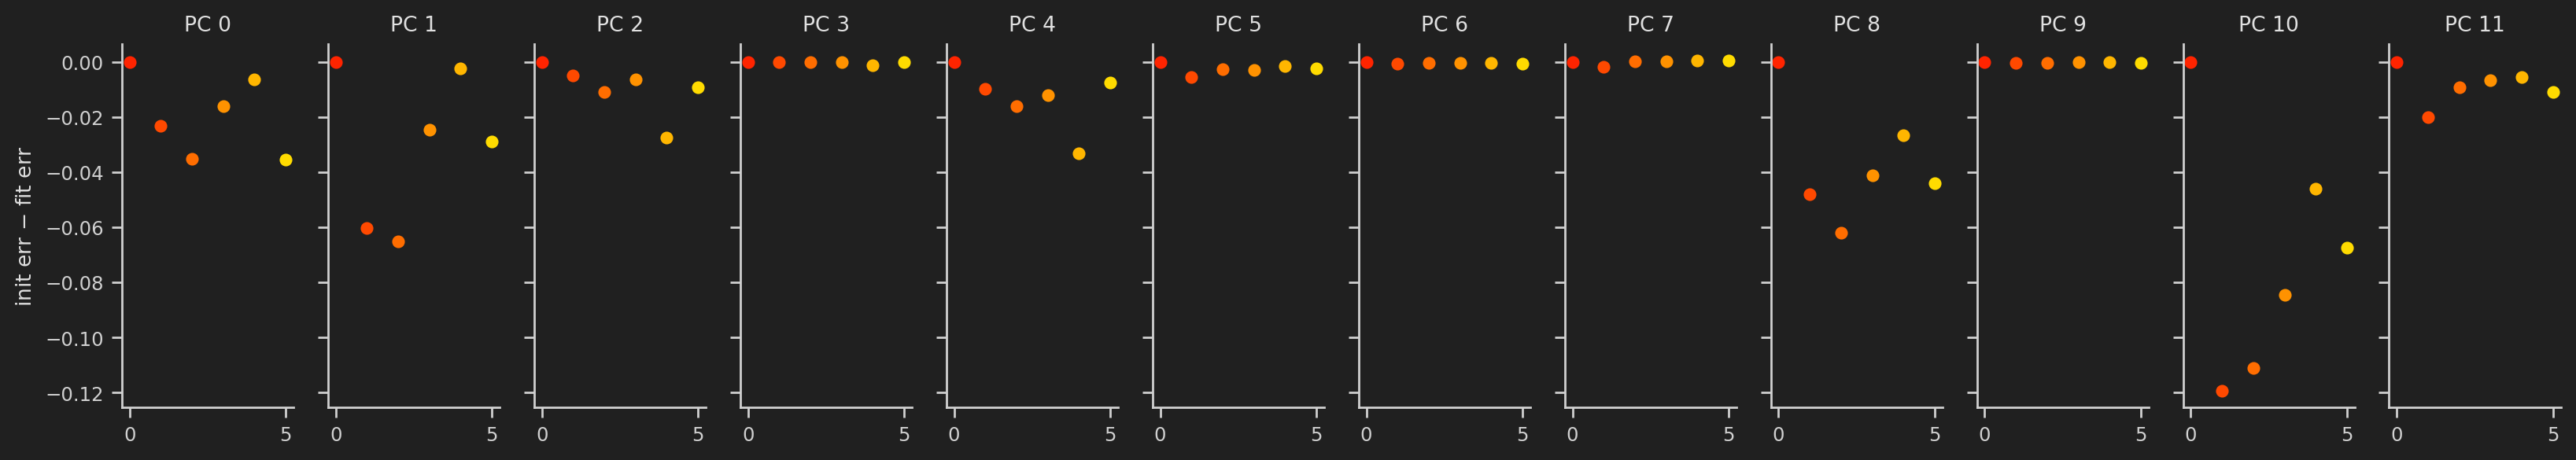

In [173]:
fig, ax = plt.subplots(1, 12, figsize = (20, 3), sharey = True)
for dim, a in enumerate(ax):
    for i, s in enumerate(slices):
        a.plot([i], [ini_dim_reconst_err[s][dim] - fit_dim_reconst_err[s][dim]],
            'o', color = age_pal[meta['tgt_age'][s]])
    a.set_title(f'PC {dim}')
ax[0].set_ylabel("init err $-$ fit err")
sns.despine()

### Reconstruction (instead of population diff) plots

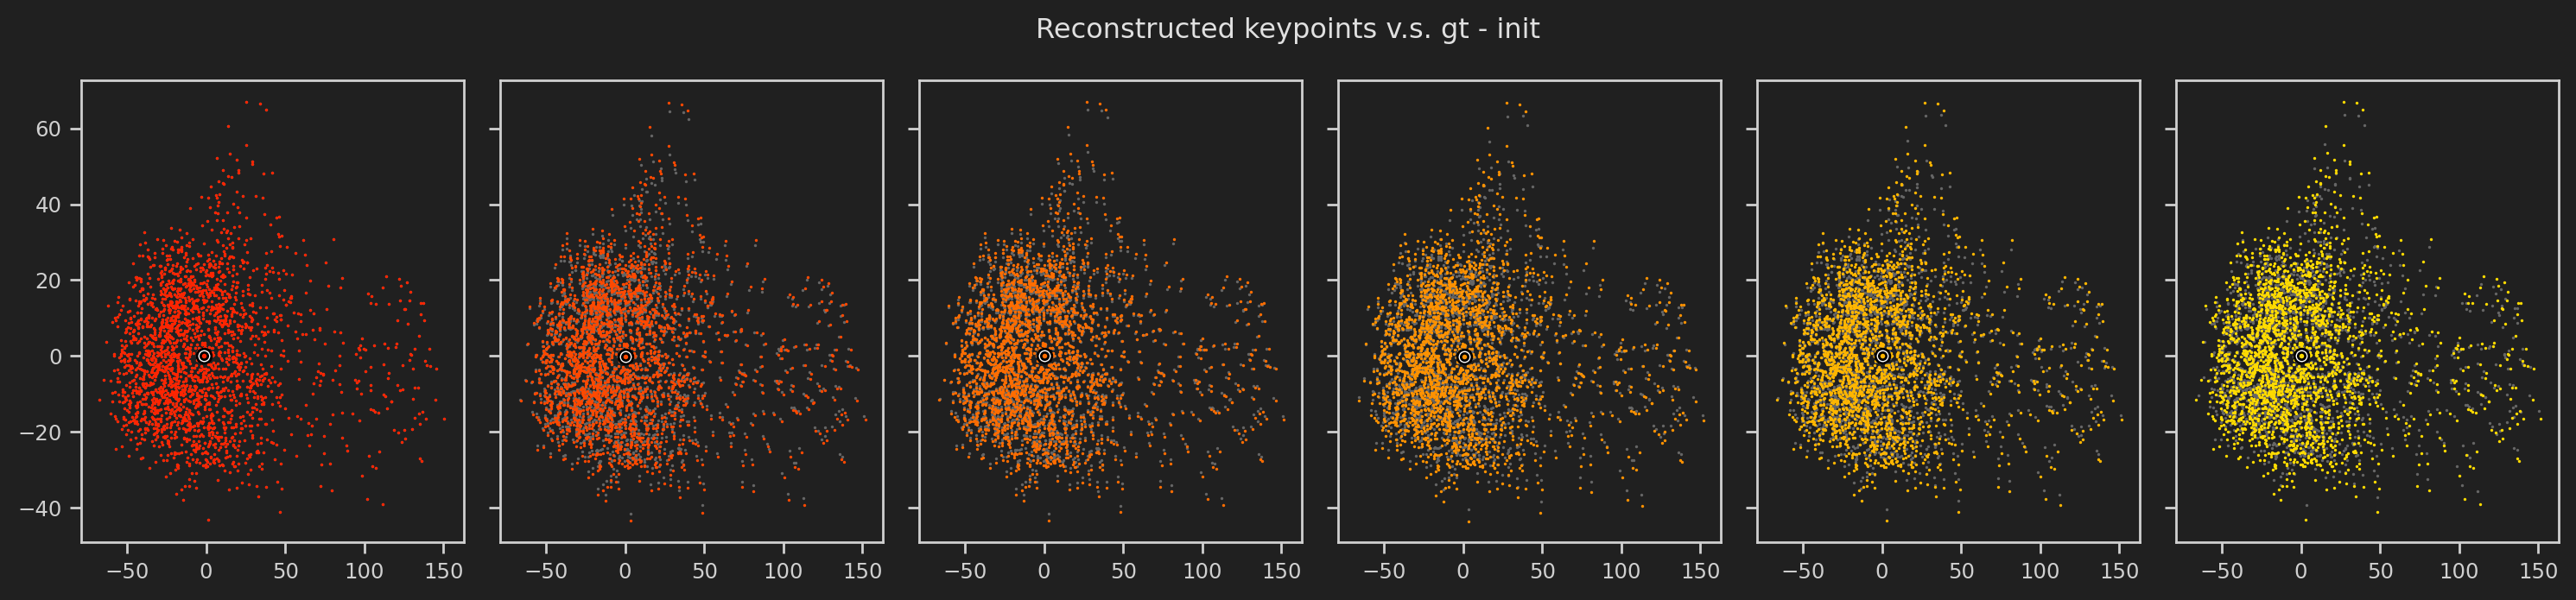

In [ ]:
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(
    len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True,
    subplot_kw = dict(sharex = True, sharey = True))


for ax, sess in zip(axes, pcs):
    bg_data = all_pcs[slices[sess]]
    sess_data = ini_all_pcs[slices[sess]]
    tgt_clr = age_pal[meta['tgt_age'][sess]]
    
    ax.scatter(
        bg_data[:, xaxis], bg_data[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True, zorder = 1)
    
    ax.scatter(
        sess_data[:, xaxis], sess_data[:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = tgt_clr, rasterized = True, zorder = 1)
    
    ax.plot(bg_data.mean(axis = 0)[[xaxis]], bg_data.mean(axis = 0)[[yaxis]],
        'o', color = 'w', mec = 'k', mew = 1, ms = 6, zorder = 4)
    
    ax.plot(sess_data.mean(axis = 0)[[xaxis]], sess_data.mean(axis = 0)[[yaxis]],
        'o', color = tgt_clr, mec = 'k', mew = 1, ms = 3, zorder = 4)
    
    # ax.set_axis_off()

fig.suptitle("Reconstructed keypoints v.s. gt - init")
fig.tight_layout()

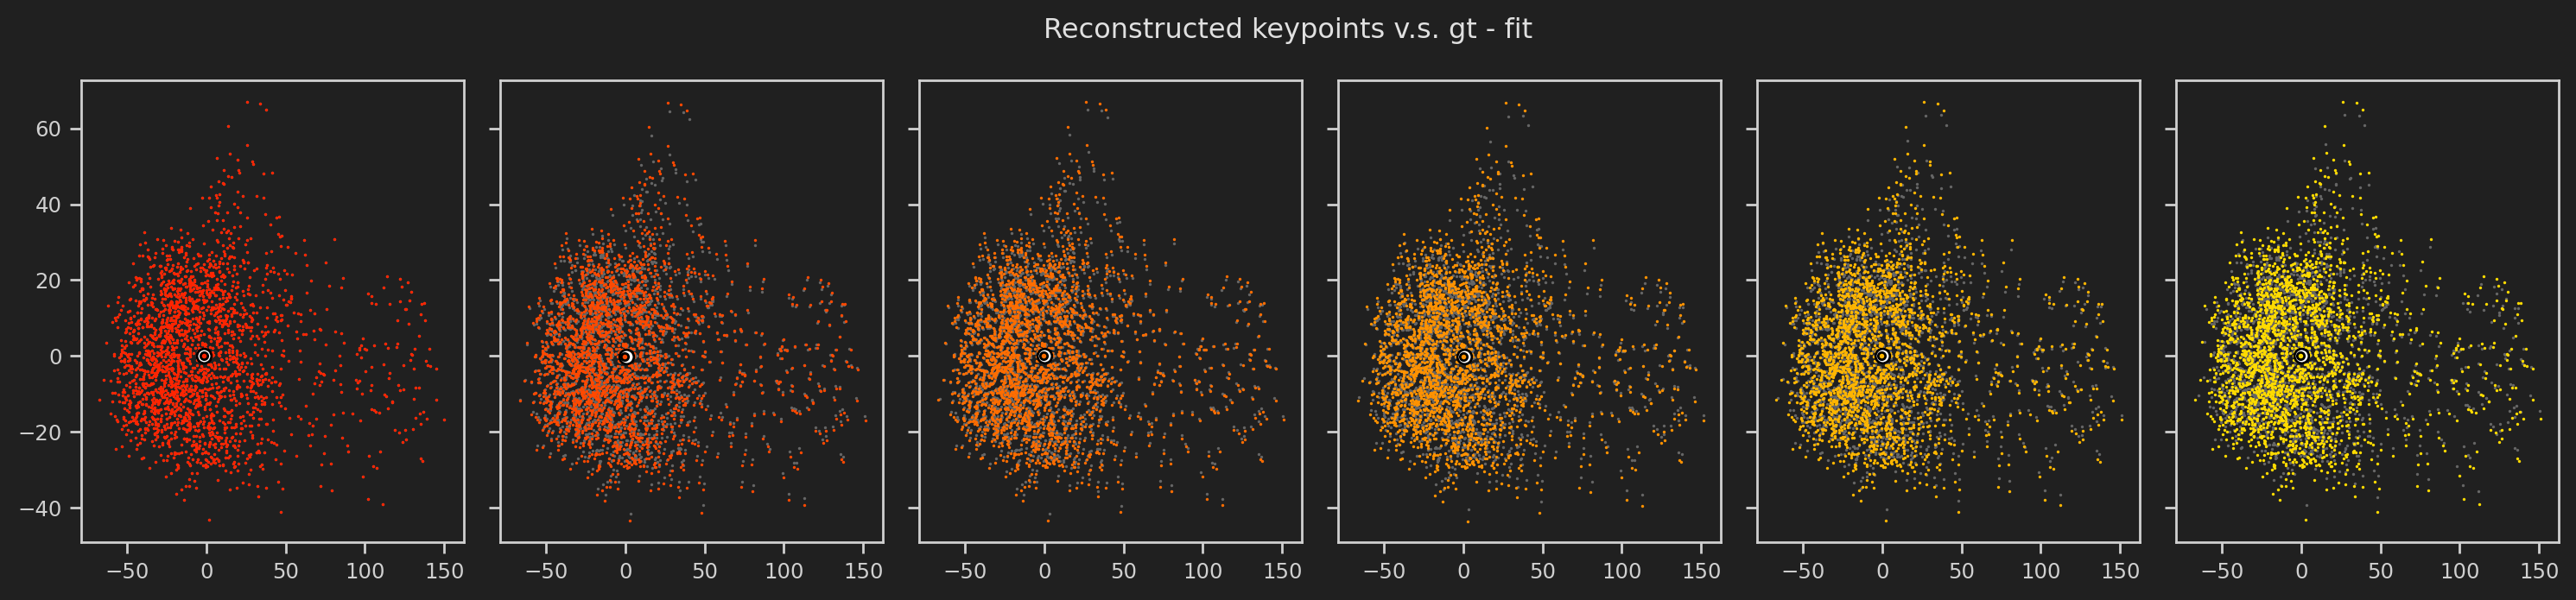

In [189]:
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(
    len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True,
    subplot_kw = dict(sharex = True, sharey = True))


for ax, sess in zip(axes, pcs):
    bg_data = all_pcs[slices[sess]]
    sess_data = fit_all_pcs[slices[sess]]
    tgt_clr = age_pal[meta['tgt_age'][sess]]
    
    ax.scatter(
        bg_data[:, xaxis], bg_data[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True, zorder = 1)
    
    ax.scatter(
        sess_data[:, xaxis], sess_data[:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = tgt_clr, rasterized = True, zorder = 1)
    
    ax.plot(bg_data.mean(axis = 0)[[xaxis]], bg_data.mean(axis = 0)[[yaxis]],
        'o', color = 'w', mec = 'k', mew = 1, ms = 6, zorder = 4)
    
    ax.plot(sess_data.mean(axis = 0)[[xaxis]], sess_data.mean(axis = 0)[[yaxis]],
        'o', color = tgt_clr, mec = 'k', mew = 1, ms = 3, zorder = 4)
    
    # ax.set_axis_off()

fig.suptitle("Reconstructed keypoints v.s. gt - fit")
fig.tight_layout()

In [154]:
# why does the plot not overlap perfectly for 3wk_m0
ref_ix = meta['session_ix'][ref_sess]
C, pop_d, sess_d = afm.get_transform(init.morph)
print(C[ref_ix])
print(pop_d)
print(sess_d[ref_ix])

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[ 32.625843    13.069685    14.9985285    0.25904837  11.050204
  -7.7811666   -0.14253913  -9.187248    49.01611     -0.07910018
  10.84315     41.490067    10.22484     16.379877    41.677906
 -10.325489    16.904634    59.15986     -0.3422534    0.50475675
   7.4874845    7.296163   -19.379932    18.099234    11.63833
 -21.782368     7.8067636   -8.498002   -19.378256    17.467043
 -13.84485    -21.525276    43.01996      6.1797194  -16.278618
  42.777252    -6.243335   -15.935876  ]
[ 32.625843    13.069685    14.9985285    0.25904837  11.050204
  -7.7811666   -0.14253913  -9.187248    49.01611     -0.07910018
  10.84315     41.490067    10.22484     16.379877    41.677906
 -10.325489    16.904634    59.15986     -0.3422534    0.50475675
   7.4874845    7.296163   -19.379932    18.099234    11.63833
 -21.782368     7.8067636   -

In [167]:

ref_pose = afm.inverse_transform(
    init.morph, feats[ref_sess], ref_ix)
copied_poses = jnp.concatenate([ref_pose for _ in range(init.morph.N)])
ref_reconst = afm.transform(
    init.morph, copied_poses, dataset['subject_ids'])[slices[ref_sess]]

ref_orig_pcs = pca.fit_transform(feats[ref_sess])
ref_reconst_pcs = pca.fit_transform(ref_reconst)

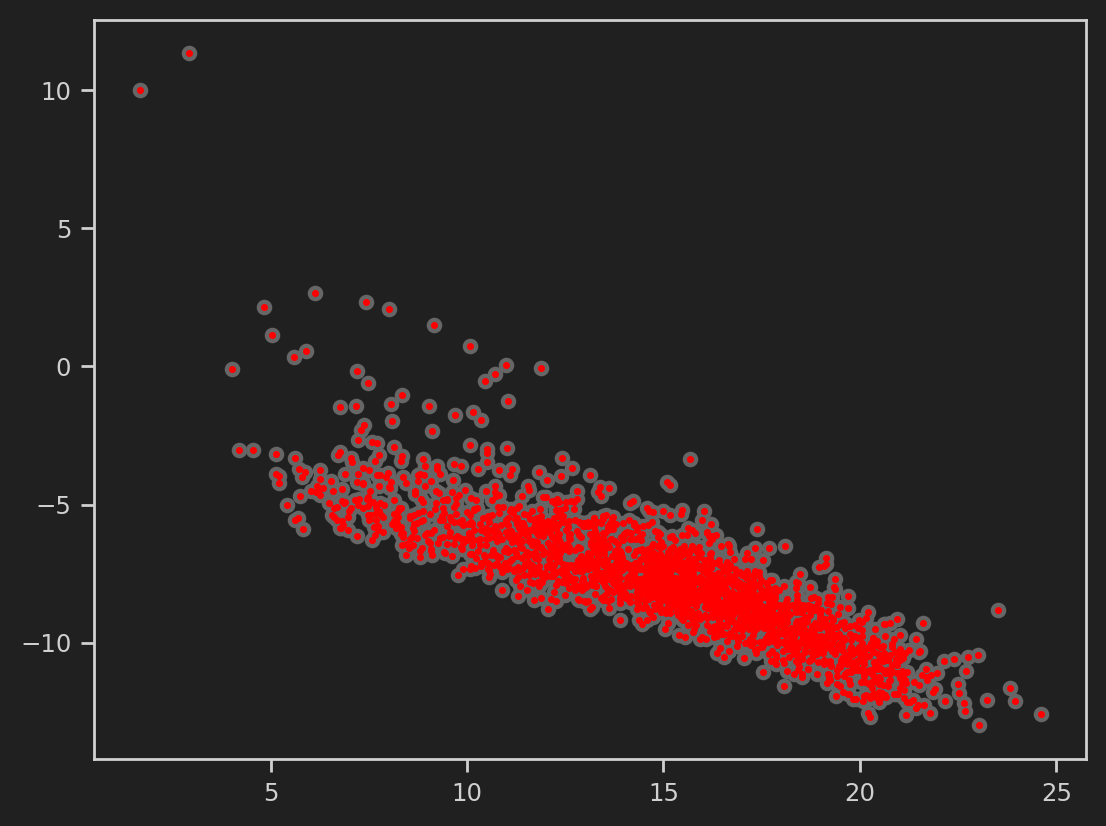

NameError: name 'ref_orig_pcs' is not defined

In [166]:
xaxis, yaxis = 2, 5
plt.scatter(feats[ref_sess][:, xaxis], feats[ref_sess][:, yaxis], color = clr.bg_dot)
plt.scatter(ref_reconst[:, xaxis], ref_reconst[:, yaxis], color = 'r', s = 3)
plt.show()

plt.scatter(ref_orig_pcs[:, xaxis], ref_orig_pcs[:, yaxis], color = clr.bg_dot)
plt.scatter(ref_reconst_pcs[:, xaxis], ref_reconst_pcs[:, yaxis], color = 'r', s = 3)
plt.show()

### Effect of a second component

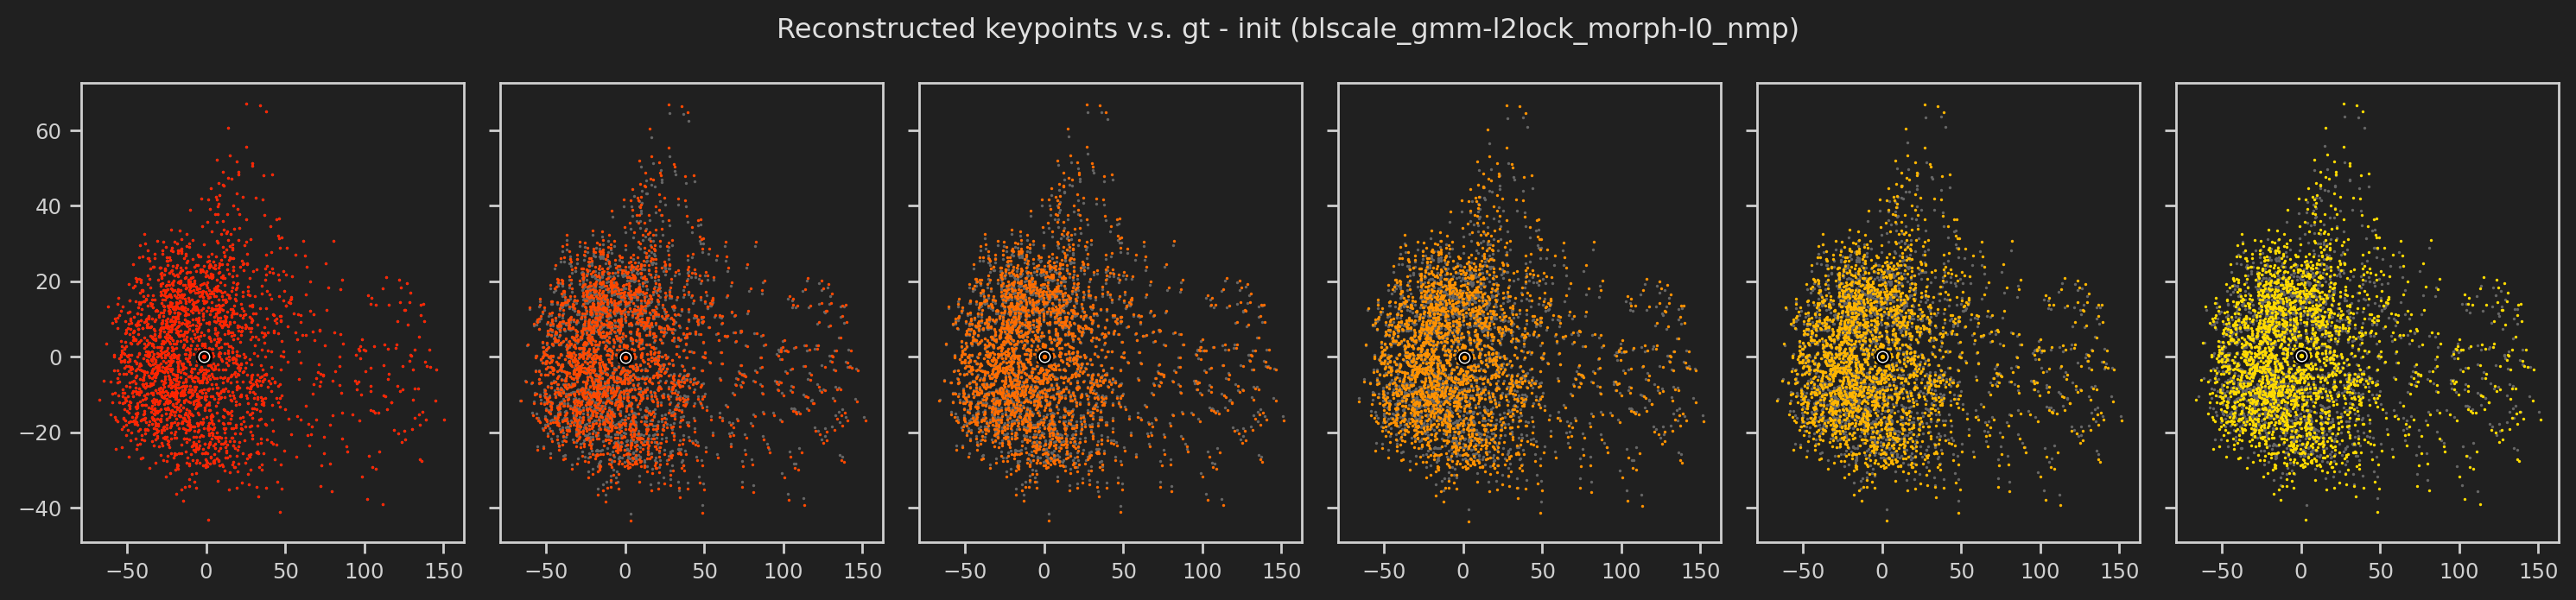

In [21]:
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(
    len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True,
    subplot_kw = dict(sharex = True, sharey = True))


for ax, sess in zip(axes, pcs):
    bg_data = all_pcs[slices[sess]]
    sess_data = ini_all_pcs[slices[sess]]
    tgt_clr = age_pal[meta['tgt_age'][sess]]
    
    ax.scatter(
        bg_data[:, xaxis], bg_data[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True, zorder = 1)
    
    ax.scatter(
        sess_data[:, xaxis], sess_data[:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = tgt_clr, rasterized = True, zorder = 1)
    
    ax.plot(bg_data.mean(axis = 0)[[xaxis]], bg_data.mean(axis = 0)[[yaxis]],
        'o', color = 'w', mec = 'k', mew = 1, ms = 6, zorder = 4)
    
    ax.plot(sess_data.mean(axis = 0)[[xaxis]], sess_data.mean(axis = 0)[[yaxis]],
        'o', color = tgt_clr, mec = 'k', mew = 1, ms = 3, zorder = 4)
    
    # ax.set_axis_off()

fig.suptitle(f"Reconstructed keypoints v.s. gt - init ({model_name})")
fig.tight_layout()

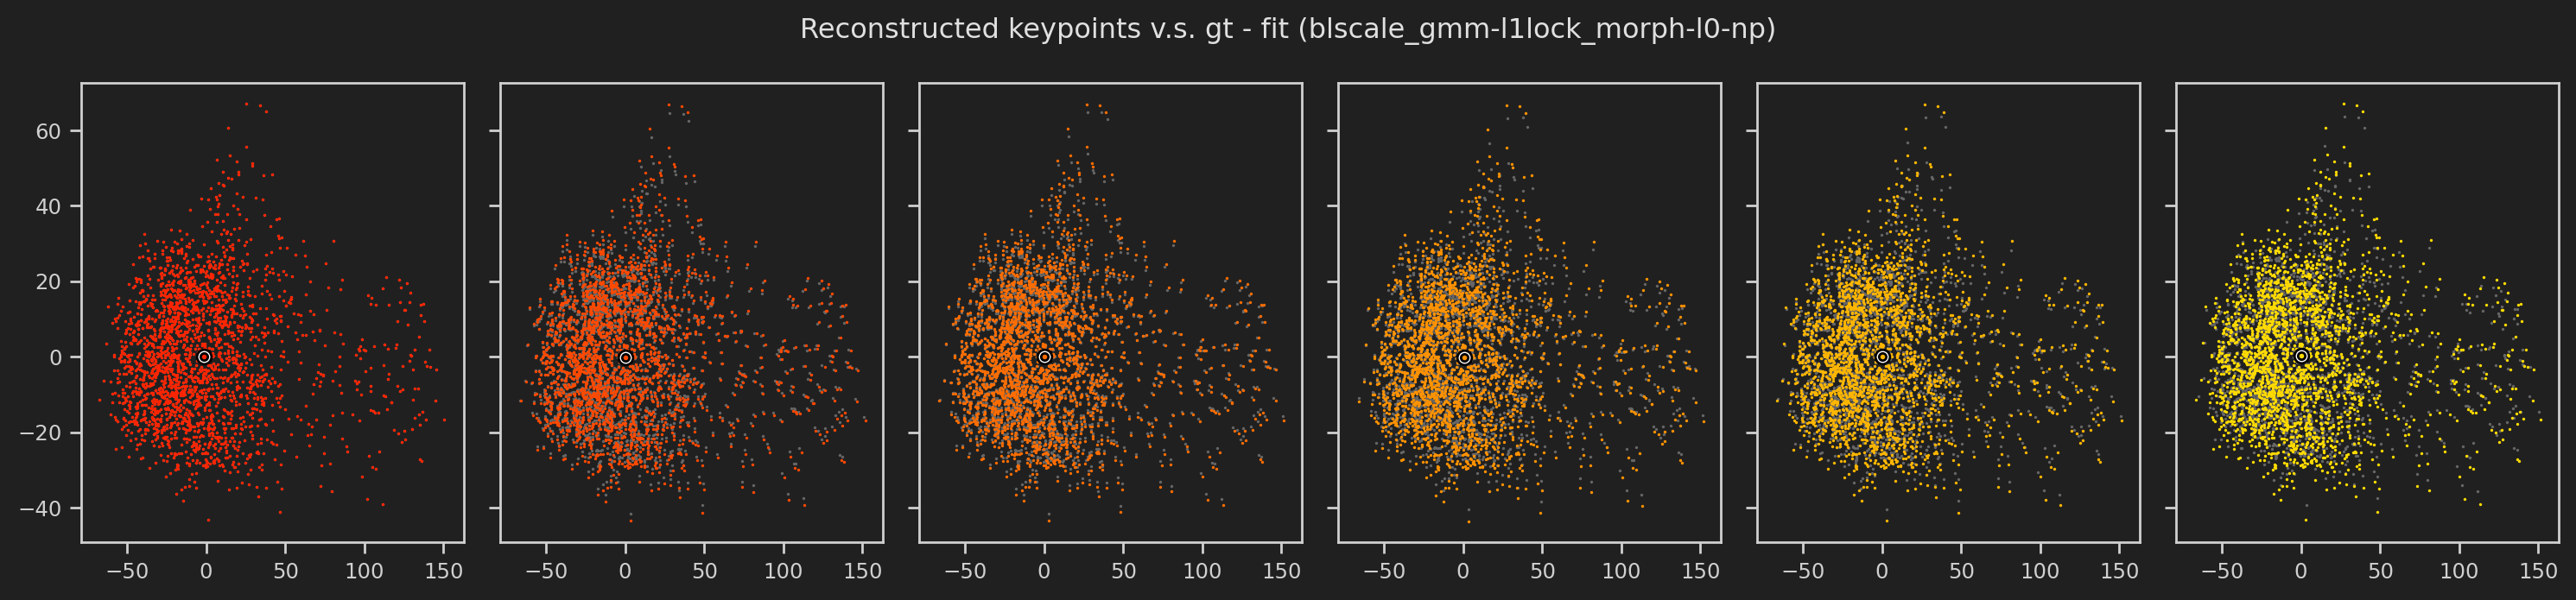

In [215]:
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(
    len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True,
    subplot_kw = dict(sharex = True, sharey = True))


for ax, sess in zip(axes, pcs):
    bg_data = all_pcs[slices[sess]]
    sess_data = fit_all_pcs[slices[sess]]
    tgt_clr = age_pal[meta['tgt_age'][sess]]
    
    ax.scatter(
        bg_data[:, xaxis], bg_data[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True, zorder = 1)
    
    ax.scatter(
        sess_data[:, xaxis], sess_data[:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = tgt_clr, rasterized = True, zorder = 1)
    
    ax.plot(bg_data.mean(axis = 0)[[xaxis]], bg_data.mean(axis = 0)[[yaxis]],
        'o', color = 'w', mec = 'k', mew = 1, ms = 6, zorder = 4)
    
    ax.plot(sess_data.mean(axis = 0)[[xaxis]], sess_data.mean(axis = 0)[[yaxis]],
        'o', color = tgt_clr, mec = 'k', mew = 1, ms = 3, zorder = 4)
    
    # ax.set_axis_off()

fig.suptitle(f"Reconstructed keypoints v.s. gt - fit ({model_name})")
fig.tight_layout()

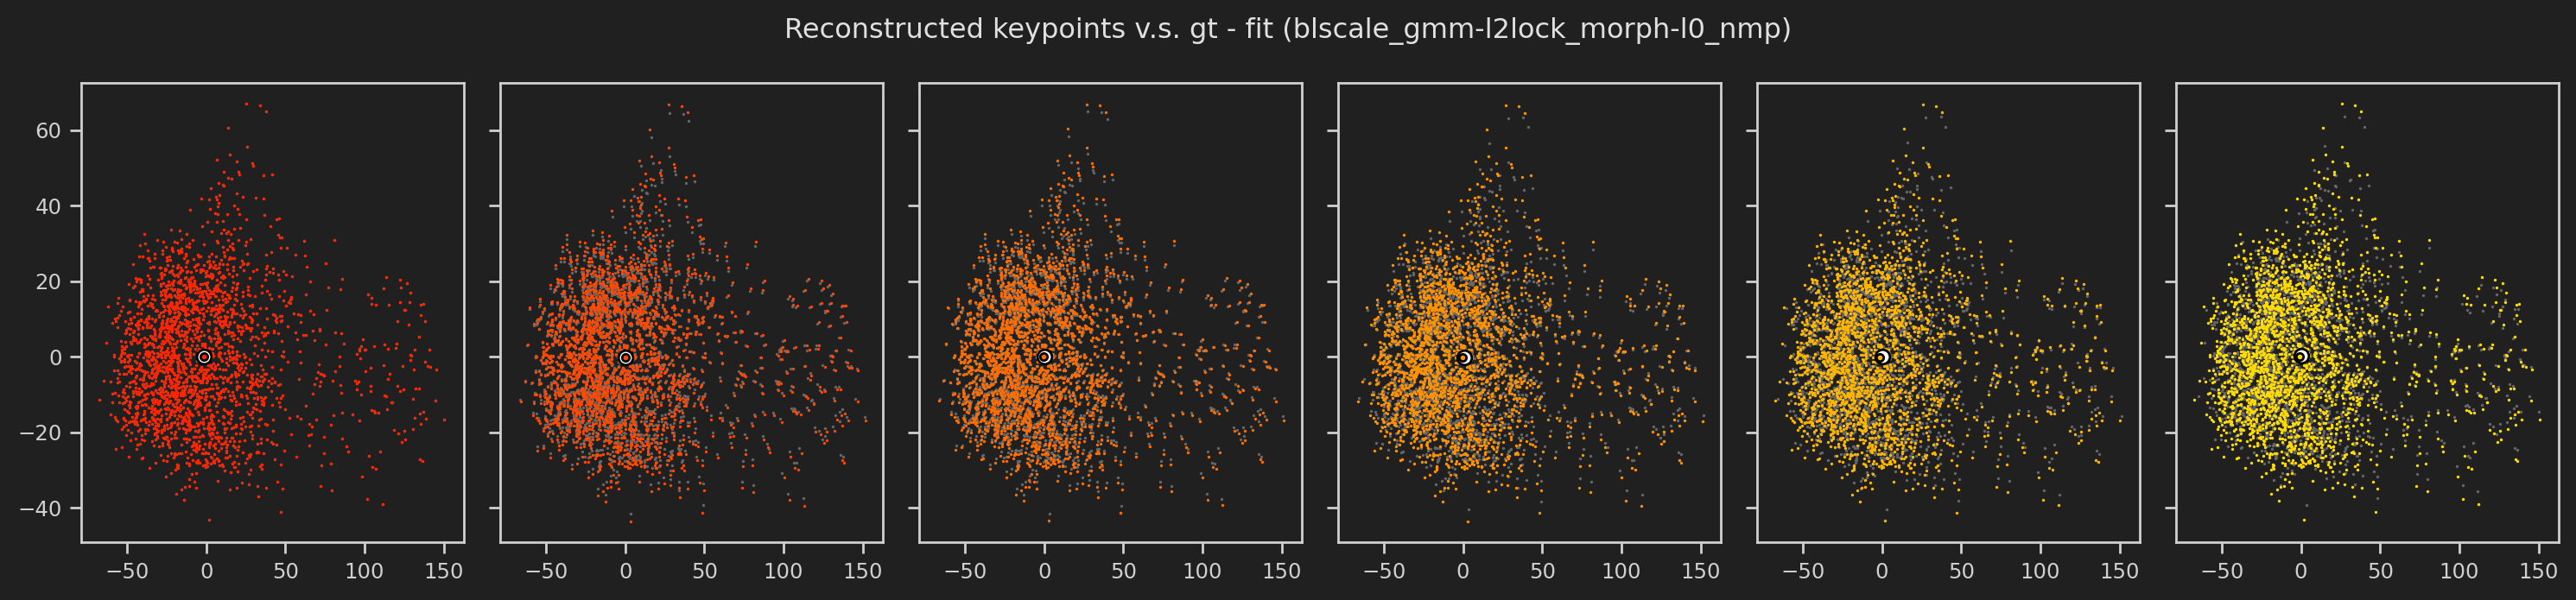

In [222]:
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(
    len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True,
    subplot_kw = dict(sharex = True, sharey = True))


for ax, sess in zip(axes, pcs):
    bg_data = all_pcs[slices[sess]]
    sess_data = fit_all_pcs[slices[sess]]
    tgt_clr = age_pal[meta['tgt_age'][sess]]
    
    ax.scatter(
        bg_data[:, xaxis], bg_data[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True, zorder = 1)
    
    ax.scatter(
        sess_data[:, xaxis], sess_data[:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = tgt_clr, rasterized = True, zorder = 1)
    
    ax.plot(bg_data.mean(axis = 0)[[xaxis]], bg_data.mean(axis = 0)[[yaxis]],
        'o', color = 'w', mec = 'k', mew = 1, ms = 6, zorder = 4)
    
    ax.plot(sess_data.mean(axis = 0)[[xaxis]], sess_data.mean(axis = 0)[[yaxis]],
        'o', color = tgt_clr, mec = 'k', mew = 1, ms = 3, zorder = 4)
    
    # ax.set_axis_off()

fig.suptitle(f"Reconstructed keypoints v.s. gt - fit ({model_name})")
fig.tight_layout()

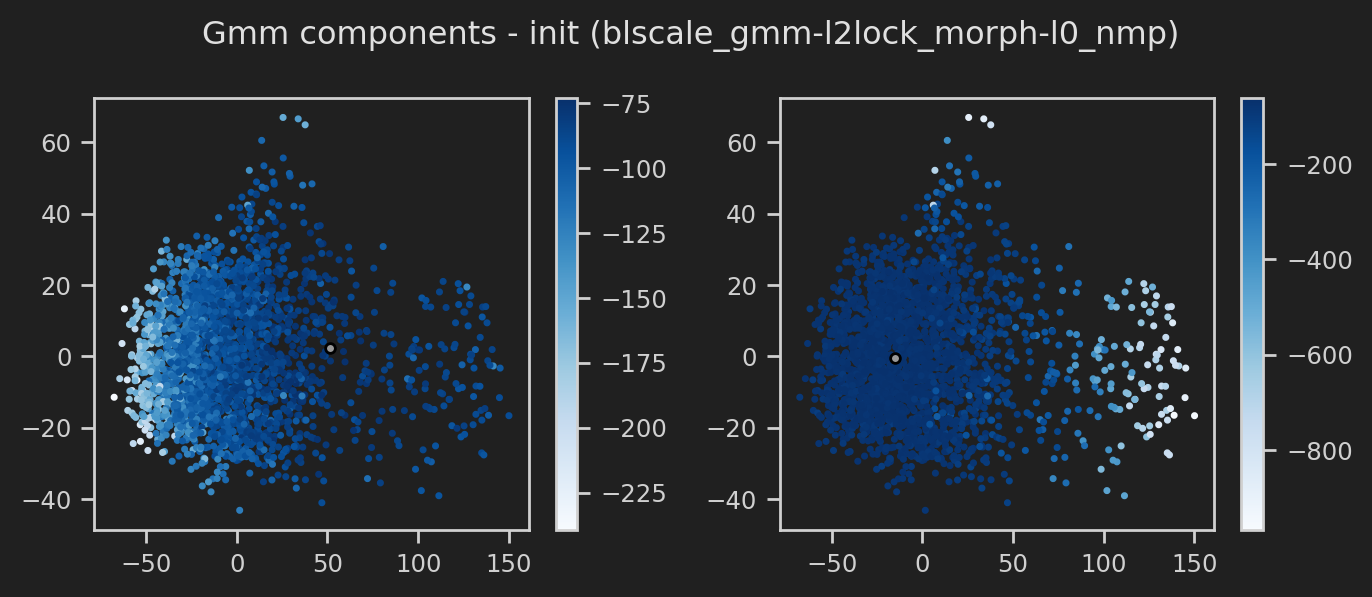

In [239]:
params = init.posespace
xaxis, yaxis = 0, 1

ref_poses = feats[ref_sess] # since identity transform
logprobs = gmm.pose_logprob(params, ref_poses, meta['session_ix'][ref_sess])
dots = all_pcs[slices[ref_sess]]
mean_pcs = pca.transform(params.means)

fig, axes, ax_grid = viz.struct.flat_grid(params.L, n_col = 2, ax_size = (3.5, 3), return_grid=True)
for i_comp, ax in enumerate(axes):
    
    mappable = ax.scatter(dots[:, xaxis], dots[:, yaxis],
        c = logprobs[:, i_comp], cmap = 'Blues', s = 3, zorder = 1)
    plt.colorbar(mappable, ax = ax)

    ax.plot([mean_pcs[i_comp, xaxis]], [mean_pcs[i_comp, yaxis]],
        'o', color = '.6', mec = 'k', mew = 1, ms = 3.5)
fig.suptitle(f"Gmm components - init ({model_name})")
plt.tight_layout()

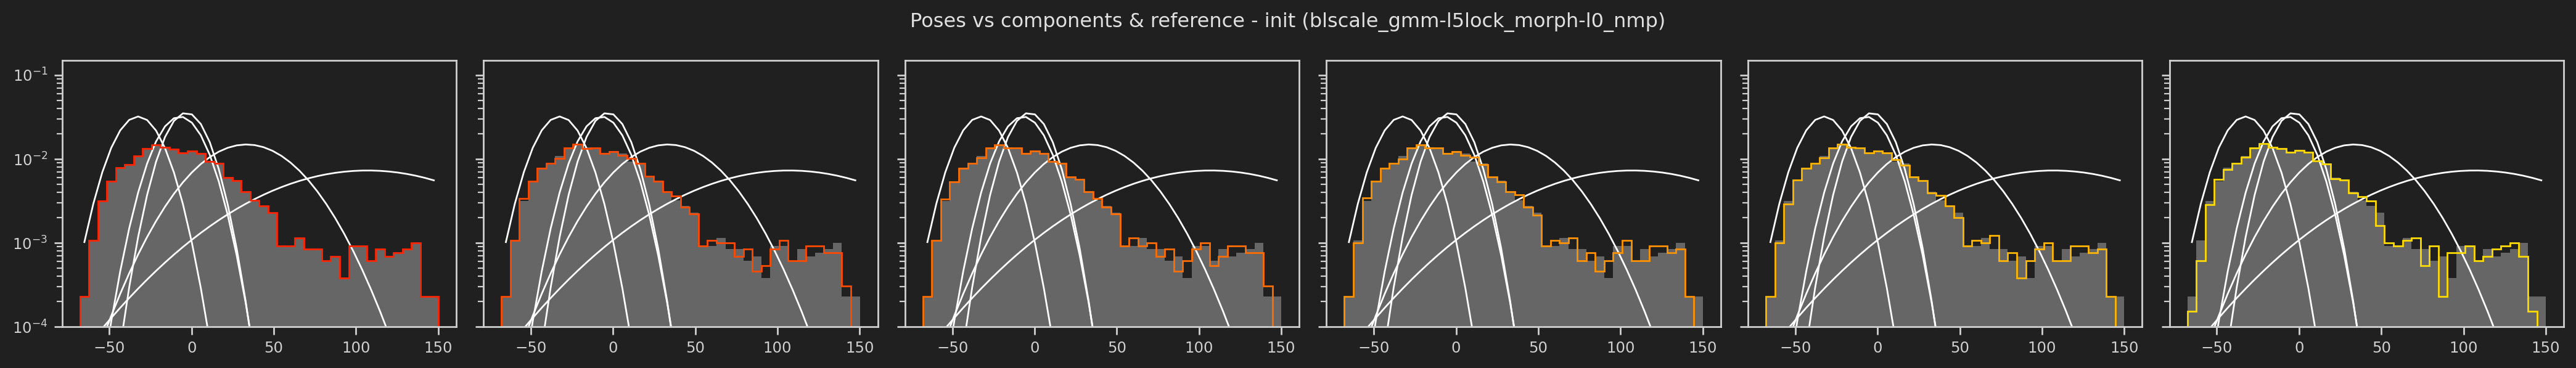

In [79]:
xaxis = 0
params = init
poses = afm.inverse_transform(params.morph, dataset['keypts'], dataset['subject_ids'])
pose_pcs = pca.transform(poses)
pc_means = pca.transform(params.posespace.means)
pc_covs = pca.components_.T @ params.posespace.covariances() @ pca.components_

fig, axes, ax_grid = viz.struct.flat_grid(params.morph.N, n_col = 6, ax_size = (3.5, 3), return_grid=True,
    subplot_kw = dict(sharey = True))
bins = np.histogram_bin_edges(pose_pcs[:, xaxis], bins = 40)
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 1.5e-1)
    ax.hist(pose_pcs[slices[ref_sess]][:, xaxis], bins = bins, color = clr.bg_dot, density=True)
bin_centers = (bins[1:] + bins[:-1]) / 2

component_probs = tfp.distributions.Normal(
    loc = jnp.array(pc_means[:, xaxis]), scale = jnp.array(pc_covs[:, xaxis, xaxis]),
).prob(bin_centers[:, None])

for ax in axes:
    for i_comp in range(params.posespace.L):
        ax.plot(bin_centers, component_probs[:, i_comp], lw = 1, color = 'w')

for i_sess, sess in enumerate(slices):
    axes[i_sess].hist(pose_pcs[slices[sess]][:, xaxis], bins = bins,
        histtype = 'step', facecolor = None, edgecolor = age_pal[meta['tgt_age'][sess]],
        linewidth = 1, density=True)

fig.suptitle(f"Poses vs components & reference - init ({model_name})")
plt.tight_layout()
plt.savefig(f"{plot_dir}/{model_name}/plots-comps_init.jpg", dpi = 300)

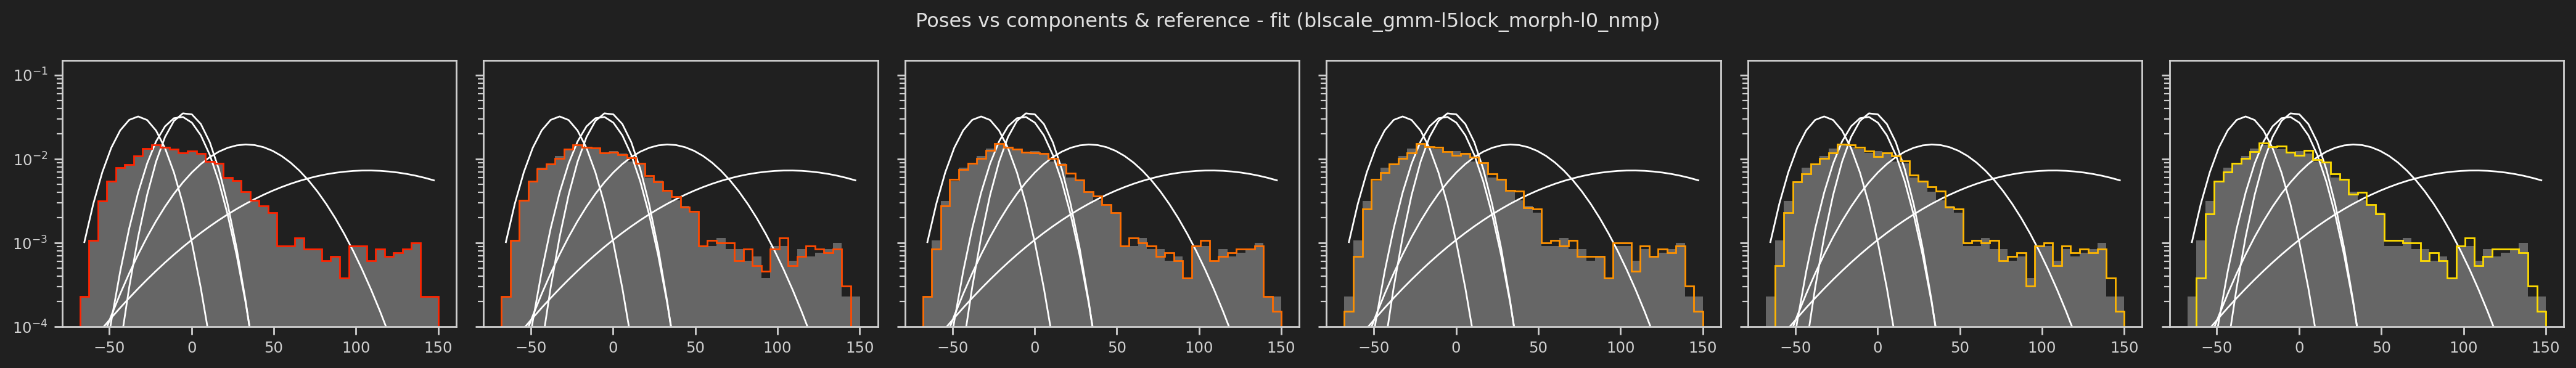

In [80]:
xaxis = 0
params = fit['fit_params']
poses = afm.inverse_transform(params.morph, dataset['keypts'], dataset['subject_ids'])
pose_pcs = pca.transform(poses)
pc_means = pca.transform(params.posespace.means)
pc_covs = pca.components_.T @ params.posespace.covariances() @ pca.components_

fig, axes, ax_grid = viz.struct.flat_grid(params.morph.N, n_col = 6, ax_size = (3.5, 3), return_grid=True,
    subplot_kw = dict(sharey = True))
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 1.5e-1)
    ax.hist(pose_pcs[slices[ref_sess]][:, xaxis], bins = bins, color = clr.bg_dot, density=True)
bin_centers = (bins[1:] + bins[:-1]) / 2

component_probs = tfp.distributions.Normal(
    loc = jnp.array(pc_means[:, xaxis]), scale = jnp.array(pc_covs[:, xaxis, xaxis]),
).prob(bin_centers[:, None])

for ax in axes:
    for i_comp in range(params.posespace.L):
        ax.plot(bin_centers, component_probs[:, i_comp], lw = 1, color = 'w')

for i_sess, sess in enumerate(slices):
    axes[i_sess].hist(pose_pcs[slices[sess]][:, xaxis], bins = bins,
        histtype = 'step', facecolor = None, edgecolor = age_pal[meta['tgt_age'][sess]],
        linewidth = 1, density=True)

fig.suptitle(f"Poses vs components & reference - fit ({model_name})")
plt.tight_layout()
plt.savefig(f"{plot_dir}/{model_name}/plots-comps_fit.jpg", dpi = 300)

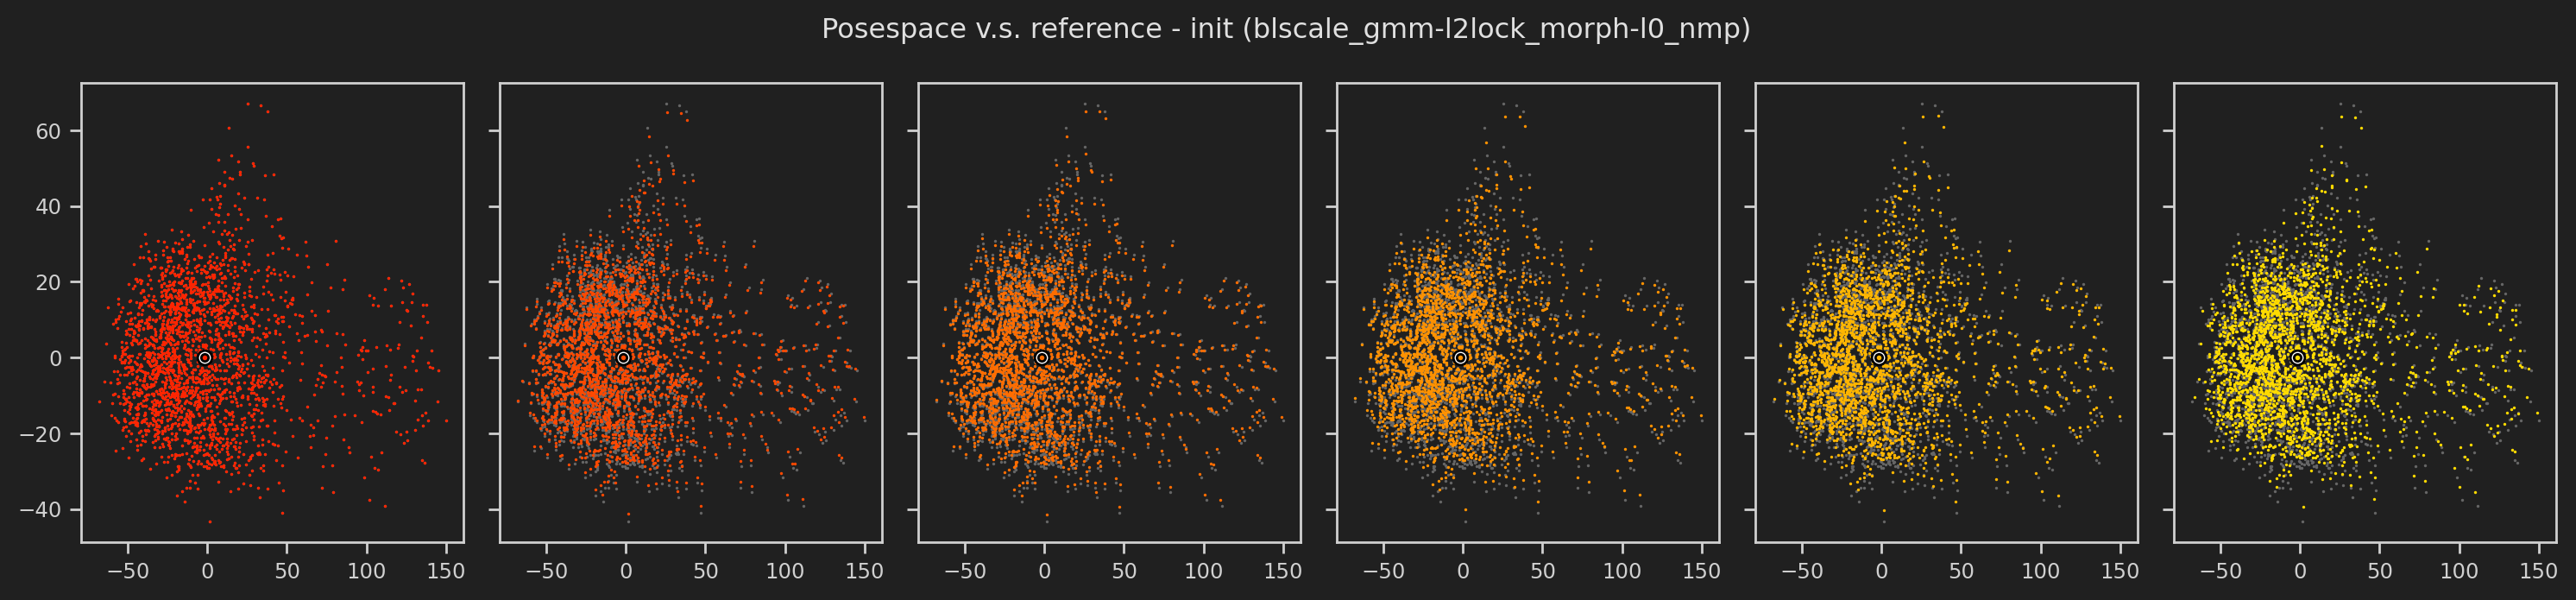

In [24]:
params = init
poses = afm.inverse_transform(params.morph, dataset['keypts'], dataset['subject_ids'])
pose_pcs = pca.transform(poses)
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(
    len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True,
    subplot_kw = dict(sharex = True, sharey = True))


for ax, sess in zip(axes, pcs):
    bg_data = pose_pcs[slices[ref_sess]]
    sess_data = pose_pcs[slices[sess]]
    tgt_clr = age_pal[meta['tgt_age'][sess]]
    
    ax.scatter(
        bg_data[:, xaxis], bg_data[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True, zorder = 1)
    
    ax.scatter(
        sess_data[:, xaxis], sess_data[:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = tgt_clr, rasterized = True, zorder = 1)
    
    ax.plot(bg_data.mean(axis = 0)[[xaxis]], bg_data.mean(axis = 0)[[yaxis]],
        'o', color = 'w', mec = 'k', mew = 1, ms = 6, zorder = 4)
    
    ax.plot(sess_data.mean(axis = 0)[[xaxis]], sess_data.mean(axis = 0)[[yaxis]],
        'o', color = tgt_clr, mec = 'k', mew = 1, ms = 3, zorder = 4)
    
    # ax.set_axis_off()

fig.suptitle(f"Posespace v.s. reference - init ({model_name})")
fig.tight_layout()

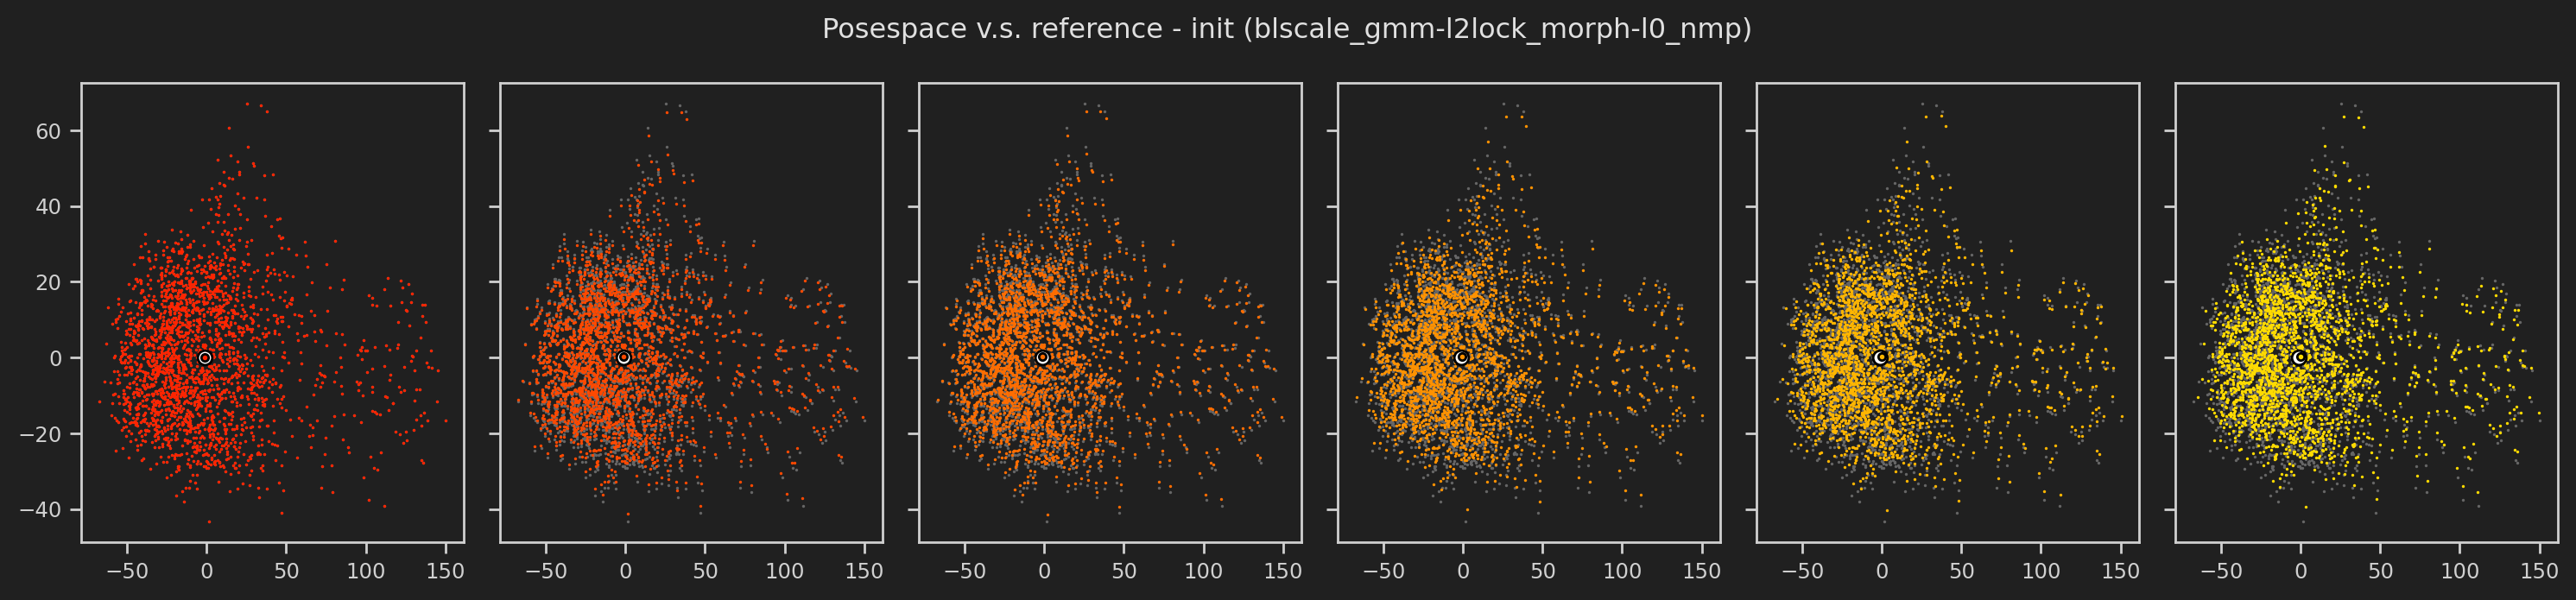

In [25]:
params = fit['fit_params']
poses = afm.inverse_transform(params.morph, dataset['keypts'], dataset['subject_ids'])
pose_pcs = pca.transform(poses)
xaxis, yaxis = 0, 1

age_pal = viz.defaults.age_pal(meta['tgt_age'], func = viz.defaults.autumn_pal)
fig, axes, ax_grid = viz.struct.flat_grid(
    len(pcs), n_col = 6, ax_size = (2.5, 3.5), return_grid = True,
    subplot_kw = dict(sharex = True, sharey = True))


for ax, sess in zip(axes, pcs):
    bg_data = pose_pcs[slices[ref_sess]]
    sess_data = pose_pcs[slices[sess]]
    tgt_clr = age_pal[meta['tgt_age'][sess]]
    
    ax.scatter(
        bg_data[:, xaxis], bg_data[:, yaxis],
        s = 1.5, marker = 'o', color = clr.bg_dot, lw = 0, rasterized = True, zorder = 1)
    
    ax.scatter(
        sess_data[:, xaxis], sess_data[:, yaxis],
        s = 1.5, marker = 'o', lw = 0,
        color = tgt_clr, rasterized = True, zorder = 1)
    
    ax.plot(bg_data.mean(axis = 0)[[xaxis]], bg_data.mean(axis = 0)[[yaxis]],
        'o', color = 'w', mec = 'k', mew = 1, ms = 6, zorder = 4)
    
    ax.plot(sess_data.mean(axis = 0)[[xaxis]], sess_data.mean(axis = 0)[[yaxis]],
        'o', color = tgt_clr, mec = 'k', mew = 1, ms = 3, zorder = 4)
    
    # ax.set_axis_off()

fig.suptitle(f"Posespace v.s. reference - init ({model_name})")
fig.tight_layout()